# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datasets.

**This time we are going to use a CNN-based autoencoder.**

In [1]:
!pip install -r requirements.txt | grep -v "already"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=f11b18a96419ab600ea7e50c70fcb18dc0fa7a7d6103e1c865c234858351f5d3
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

In [12]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [13]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

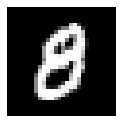

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Convolutional Autoencoder

Write your own CNN autoencoder. Use at least 2 blocks Convolution + ReLU + MaxPooling as _encoder_, and then an equivalent number of upsampling operations (either Transposed Convolutions+ReLU or Upsample+Conv+ReLU) followed by a Sigmoid activation.

In [16]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2)
        
        )
        # YOUR CODE HERE
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
#             nn.ConvTranspose2d(3, 1, 2, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 1, 3, padding = 1),
            nn.Sigmoid()
        )# YOUR CODE HERE
        
        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        return self.auto_encoder(x)
    
# initialize the NN
model = Autoencoder()

## Loss Function

Set up here a loss function that makes sense for the task at hand (look at the lesson again if you don't remember what this should be):

In [17]:
# specify loss function
criterion = nn.MSELoss()# YOUR CODE HERE

## Training

The training loop is similar to a normal training loop - however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

Complete the training loop below. As usual, you need to perform the forward and the backward pass.

In [18]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [19]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        # YOUR CODE HERE
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs.flatten(), images.flatten())
        loss.backward()
        
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:25<00:00,  2.14s/it]


Epoch: 1 	Training Loss: 35.637002	Valid Loss: 15.530292


Validating: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]


Epoch: 2 	Training Loss: 8.381029	Valid Loss: 5.933210


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.15s/it]


Epoch: 3 	Training Loss: 5.304768	Valid Loss: 4.621317


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


Epoch: 4 	Training Loss: 4.418415	Valid Loss: 4.262291


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Epoch: 5 	Training Loss: 4.013982	Valid Loss: 3.849797


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 6 	Training Loss: 3.674565	Valid Loss: 3.475685


Validating: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


Epoch: 7 	Training Loss: 3.448618	Valid Loss: 3.173808


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


Epoch: 8 	Training Loss: 3.324479	Valid Loss: 3.169428


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.75s/it]


Epoch: 9 	Training Loss: 3.224587	Valid Loss: 2.872705


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 10 	Training Loss: 2.963849	Valid Loss: 2.884328


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.78s/it]


Epoch: 11 	Training Loss: 2.824427	Valid Loss: 3.181594


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.77s/it]


Epoch: 12 	Training Loss: 2.786594	Valid Loss: 2.580951


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 13 	Training Loss: 2.636324	Valid Loss: 2.562344


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.96s/it]


Epoch: 14 	Training Loss: 2.573439	Valid Loss: 2.451638


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.77s/it]


Epoch: 15 	Training Loss: 2.505010	Valid Loss: 2.486356


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


Epoch: 16 	Training Loss: 2.440656	Valid Loss: 2.345605


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.12s/it]


Epoch: 17 	Training Loss: 2.370673	Valid Loss: 2.320025


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


Epoch: 18 	Training Loss: 2.356299	Valid Loss: 2.198652


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.85s/it]


Epoch: 19 	Training Loss: 2.291749	Valid Loss: 2.147450


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 20 	Training Loss: 2.316851	Valid Loss: 2.167120


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.71s/it]


Epoch: 21 	Training Loss: 2.195399	Valid Loss: 2.188411


Validating: 100%|██████████| 12/12 [00:26<00:00,  2.18s/it]


Epoch: 22 	Training Loss: 2.140921	Valid Loss: 2.054334


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch: 23 	Training Loss: 2.146384	Valid Loss: 2.061482


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.92s/it]


Epoch: 24 	Training Loss: 2.110494	Valid Loss: 2.009349


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.88s/it]


Epoch: 25 	Training Loss: 2.087846	Valid Loss: 2.208617


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


Epoch: 26 	Training Loss: 2.084104	Valid Loss: 1.966199


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 27 	Training Loss: 1.996686	Valid Loss: 1.935177


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


Epoch: 28 	Training Loss: 1.975720	Valid Loss: 1.871589


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 29 	Training Loss: 1.933236	Valid Loss: 1.943994


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Epoch: 30 	Training Loss: 1.974406	Valid Loss: 2.023130


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 31 	Training Loss: 1.925803	Valid Loss: 1.840960


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


Epoch: 32 	Training Loss: 1.931818	Valid Loss: 1.806426


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


Epoch: 33 	Training Loss: 1.852376	Valid Loss: 1.803915


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.85s/it]


Epoch: 34 	Training Loss: 1.845707	Valid Loss: 1.779006


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.77s/it]


Epoch: 35 	Training Loss: 1.840340	Valid Loss: 1.828202


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


Epoch: 36 	Training Loss: 1.794239	Valid Loss: 2.032114


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Epoch: 37 	Training Loss: 1.792611	Valid Loss: 1.748017


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


Epoch: 38 	Training Loss: 1.778479	Valid Loss: 1.733295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Epoch: 39 	Training Loss: 1.749256	Valid Loss: 1.700597


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.72s/it]


Epoch: 40 	Training Loss: 1.730165	Valid Loss: 1.641371


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.88s/it]


Epoch: 41 	Training Loss: 1.698399	Valid Loss: 1.641969


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.12s/it]


Epoch: 42 	Training Loss: 1.669959	Valid Loss: 1.764392


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 43 	Training Loss: 1.672124	Valid Loss: 1.595700


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.77s/it]


Epoch: 44 	Training Loss: 1.672236	Valid Loss: 1.575477


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.83s/it]


Epoch: 45 	Training Loss: 1.632293	Valid Loss: 1.588087


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


Epoch: 46 	Training Loss: 1.609343	Valid Loss: 1.610968


Validating: 100%|██████████| 12/12 [00:26<00:00,  2.21s/it]


Epoch: 47 	Training Loss: 1.595266	Valid Loss: 1.571244


Validating: 100%|██████████| 12/12 [00:19<00:00,  1.66s/it]


Epoch: 48 	Training Loss: 1.612269	Valid Loss: 1.616155


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 49 	Training Loss: 1.604148	Valid Loss: 1.646138


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.83s/it]

Epoch: 50 	Training Loss: 1.598566	Valid Loss: 1.614678


In [20]:
# Epoch: 50 	Training Loss: 1.359510	Valid Loss: 1.399772

## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [21]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


,loss,image,reconstructed
0,0.001222,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0019470091, 0.0015501067, 0.0009364014, 0..."
1,0.001656,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0019470091, 0.0015501067, 0.00092063716, ..."
2,0.000764,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0019470082, 0.0015501067, 0.00093640195, ..."
3,0.00182,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0019470119, 0.001550105, 0.00093640096, 0..."
4,0.001682,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00194701, 0.001550106, 0.000936079, 0.000..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

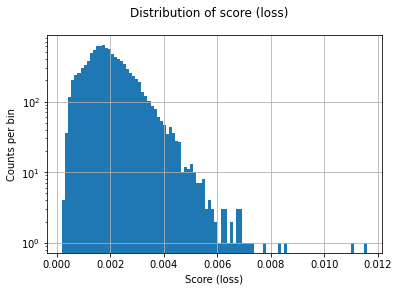

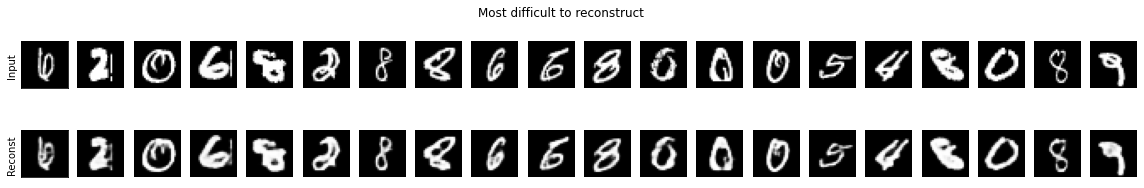

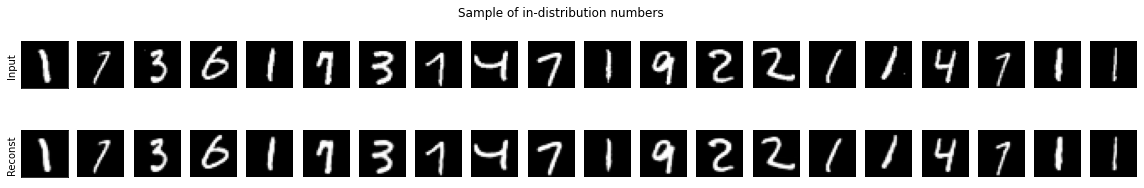

In [22]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

We got similar results as in the case of linear autoencoders, but the loss is on average much smaller (a sign that the network is much more capable of representing and reconstructing the dataset).